Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


#### Описание данных  
Данные находятся в файле /datasets/autos.csv.


Признаки:
- DateCrawled — дата скачивания анкеты из базы  
- VehicleType — тип автомобильного кузова  
- RegistrationYear — год регистрации автомобиля  
- Gearbox — тип коробки передач  
- Power — мощность (л. с.)  
- Model — модель автомобиля  
- Kilometer — пробег (км)  
- RegistrationMonth — месяц регистрации автомобиля  
- FuelType — тип топлива  
- Brand — марка автомобиля  
- NotRepaired — была машина в ремонте или нет  
- DateCreated — дата создания анкеты  
- NumberOfPictures — количество фотографий автомобиля  
- PostalCode — почтовый индекс владельца анкеты (пользователя)  
- LastSeen — дата последней активности пользователя  


Целевой признак - Price — цена (евро)


#### План по выполнению проекта:  
1) Откроем файлы.  
2) Проанализируем признаки и подготовим данные для обучения и тестирования модели.  
3) Обучим разные модели и оценим их качество на кросс-валидацией.  
4) Выберем лучшие по качеству и скорости, подберем гиперпараметры.  
5) Проверим модели на тестовой выборке.  
6) Проанализируйте скорость работы и качество моделей.  

---

Импортируем все необходимые для анализа и обучения библиотеки.

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

import time

from sklearn.model_selection import KFold, cross_val_predict

from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x)) #Limiting floats output to 2 decimal points

# 1. Подготовка данных


Откроем файл и проанализируем признаки.

In [92]:
data = pd.read_csv('/datasets/autos.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Первичный анализ показал следующее:  


- признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, вероятнее всего, не могут повлиять на качество предсказания стоимости автомобиля, соответственно, их можно удалить;
- признаки с календарными данными в текстовом формате, их надо перевести в цифровой формат даты;  
- отсутствие значений (NaN);
- присутствуют текстовые категоральные признаки, которые для обучения модели необходимо перевести в численные


In [93]:
data = data.drop(['DateCrawled','DateCreated', 
                  'NumberOfPictures', 'PostalCode','LastSeen'], axis=1) # убираем признаки, невлияющие на обучение

In [94]:
data['RegistrationYear'] = pd.to_datetime(data['RegistrationYear'], format='%Y%m%d', errors='ignore') # преобразование текста 
data['RegistrationMonth'] = pd.to_datetime(data['RegistrationMonth'], format='%Y%m%d', errors='ignore') # в формат даты

Определим отсутствующие признаки (NaN) и их объем. 

In [95]:
def missing_values_table(df):
        mis_val = df.isnull().sum() # общее количество пропусков
        mis_val_percent = 100 * df.isnull().sum() / len(df) # пропуски в %
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # составление таблицы
        
        
        # переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
                
        print ("В выборке " + str(df.shape[1]) + " столбцов,"      
            "из них " + str(mis_val_table_ren_columns.shape[0]) +
              " с пропущенными значениями.")
        
        return mis_val_table_ren_columns
    
missing_values_table(data).head()

В выборке 11 столбцов,из них 5 с пропущенными значениями.


,Missing Values,% of Total Values
NotRepaired,71154,20.10
VehicleType,37490,10.60
FuelType,32895,9.30
Gearbox,19833,5.60
Model,19705,5.60


Большое количество пропусков следующих признаков: была ли машина в ремонте или нет, тип кузова и топлива. К сожалению, восстановить эти данные, не представляется возможным. Предлагаю (пока) их оставить в таком виде.


В датасете присутствуют текстовые категоральные признаки. Для преобразования категорий в числовые данные используем LabelEncoder.

Одновременно все признаки с отсутствующими признаками (NaN) будут также преобразованы в числовые данные.

In [96]:
from sklearn.preprocessing import LabelEncoder
cols = ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

print('Shape all data: {}'.format(data.shape))

Shape all data: (354369, 11)


Проанализируем, какие признаки влияют на целевую переменную (`Price`). Для этого построим тепловую карту корреляции.

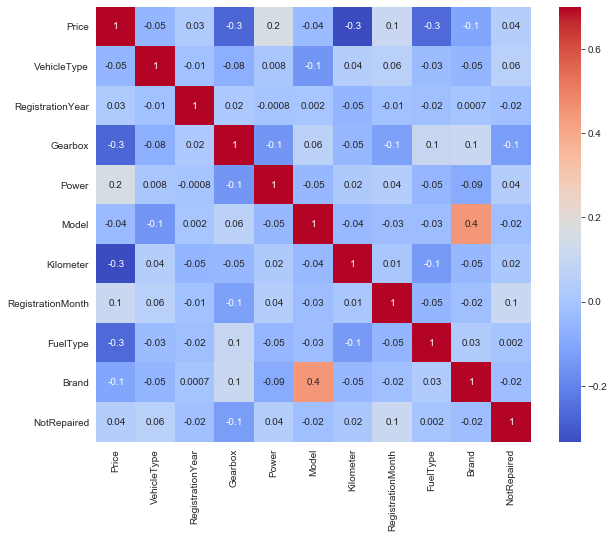

In [97]:
corrmat = data.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corrmat, annot = True, fmt='.1g', vmax=0.7, square=True, cmap= 'coolwarm')

Хорошо видно, что на цену больше всего влияют тип коробки передач, пробег, тип топлива и мощность.  

Проанализируем значения признака мощности двигателя.

In [98]:
data['Power'].describe()

count   354369.00
mean       110.09
std        189.85
min          0.00
25%         69.00
50%        105.00
75%        143.00
max      20000.00
Name: Power, dtype: float64

Обнаружились явно ошибочно данные - 0 и 20000 л.с. Предположим, что мощность обычного автомобиля варьируется в пределах от 30 до 500 л.с. (спорткар).     

Визуализируем "выбросы" и удалим их из нашего датасета.

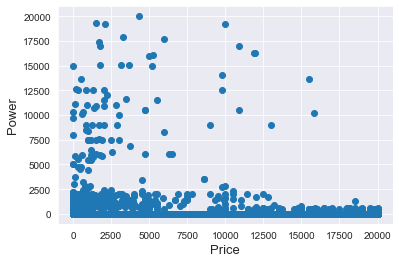

0       40225
26        291
5         103
18         51
23         44
        ...  
6512        1
1394        1
1362        1
1202        1
1999        1
Name: Power, Length: 331, dtype: int64

In [99]:
data_m = data.drop(data[(data['Power']<500) & (data['Power'] > 30)].index)

fig, ax = plt.subplots()
ax.scatter(x = data_m['Price'], y = data_m['Power'])
plt.ylabel('Power', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()
data_m['Power'].value_counts()

In [100]:
data = data.drop(data[(data['Power']>=500) | (data['Power'] < 30)].index)
data['Power'].describe() # "очищенная" от выбросов мощность 

count   312738.00
mean       120.28
std         53.13
min         30.00
25%         75.00
50%        110.00
75%        150.00
max        490.00
Name: Power, dtype: float64

Изучим признак "год регистрации автомобиля". Предположим, что в нашем датасете исторические данные по автомобилям с 1940 по 2019года, остальные - ошибочные.

1000


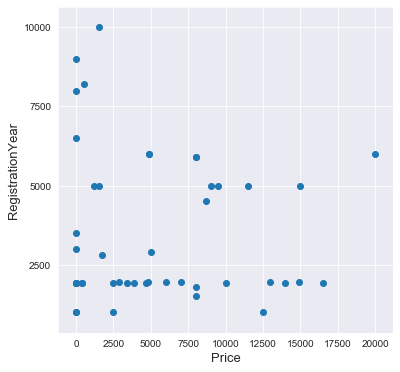

In [101]:
print(data['RegistrationYear'].min())

year_err = data.drop(data[(data['RegistrationYear']<=2019) & (data['RegistrationYear']>=1940)].index)

#fig, ax = plt.subplots()
f, ax = plt.subplots(figsize=(6,6))

major_ticks = np.arange(0, 20001, 2500)
minor_ticks = np.arange(0, 10001, 100)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.scatter(x = year_err['Price'], y = year_err['RegistrationYear'])
plt.ylabel('RegistrationYear', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

In [102]:
data = data.drop(data[(data['RegistrationYear']>=2019) | (data['RegistrationYear']<=1940)].index) # удаление ошибочных данных
print(data['RegistrationYear'].min())
data['RegistrationYear'].max()

1941


2018

И, наконец, проанализируем целевой признак `Price`.

In [103]:
print(data['Price'].describe())

data = data.drop(data[data['Price'] <= 10].index) # удалим данные с ценами ниже 10 евро
data['Price'].describe()

count   312682.00
mean      4706.16
std       4589.47
min          0.00
25%       1250.00
50%       2999.00
75%       6890.00
max      20000.00
Name: Price, dtype: float64


count   305127.00
mean      4822.68
std       4585.07
min         11.00
25%       1350.00
50%       3150.00
75%       6950.00
max      20000.00
Name: Price, dtype: float64

---

Выделим целевой признак и разделим датасет на обучающую и тестовую выборки.

In [104]:
features = data.drop('Price', axis=1)
target = data['Price']

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

print('Обучающая выборка:', X_train.shape)
print('Целевой признак обучающей выборки:', y_train.shape, '\n')

print('Тестовая выборка:',X_valid.shape)
print('Целевой признак тестовой выборки:', y_valid.shape, '\n')

Обучающая выборка: (228845, 10)
Целевой признак обучающей выборки: (228845,) 

Тестовая выборка: (76282, 10)
Целевой признак тестовой выборки: (76282,) 



# 2. Обучение моделей

Помимо библиотек для градиентного бустинга, для сравнения качества и скорости, используем LinearRegression и DecisionTreeRegressor классификаторы.

Для оценки качества моделей используем метрику RMSE (Root Mean Square Error). Напишем функцию для расчета ошибки.

In [105]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [106]:
print('- RMSE - \n')                             

pipelines = []
pipelines.append(('LightGBM', lgb.LGBMRegressor()))
pipelines.append(('CBR', CatBoostRegressor(iterations=100, silent=True)))
pipelines.append(('XGBoost', xgb.XGBRegressor(silent=True)))
pipelines.append(('GBM', GradientBoostingRegressor()))
pipelines.append(('LR', LinearRegression()))
pipelines.append(('DTR', DecisionTreeRegressor()))


for name, model in pipelines:
    start_time = time.time()
    
    kf = KFold(n_splits=5,random_state=1234, shuffle=True)
    predict = cross_val_predict(model, X_train, y_train, cv=kf)
    
    rmse_sc = rmse(y_train, predict)
    
    end_time = time.time()
    duration = end_time - start_time
    
    msg = "%s: %f (ET: %.2fs)" % (name, rmse_sc, duration)
    print(msg)

- RMSE - 

LightGBM: 1705.751678 (ET: 6.13s)
CBR: 1682.181006 (ET: 13.48s)
XGBoost: 1625.200398 (ET: 55.07s)
GBM: 1927.162942 (ET: 99.70s)
LR: 3034.799957 (ET: 0.58s)
DTR: 2099.177898 (ET: 6.29s)


Вышеприведенные результаты наглядно показывают, что качество библиотек градиентного бустинга превосходят обычные модели регрессии. Хотя, работают они медленнее.

Остановимся на 3x лучших моделях по критериям наименьшей ошибки (RMSE) и времени обучения/предсказания - LightGBM, CatBoostRegressor и XGBRegressor.

Подберём при помощи функции RandomizedSearchCV гиперпараметры и проверим, как покажут себя  модели на тестовой выборке.

# 3. Анализ моделей

In [107]:
my_scorer = make_scorer(rmse, greater_is_better=False) # зададим параметр целевой метрики качества (чем меньше, тем лучше)
cv = KFold(n_splits=5,random_state=42, shuffle=False)

lgbmr = lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
param_lgbm = {'num_leaves': sp_randint(18,24),
              'learning_rate': [0.3, 0.4, 0.5],
              'max_depth': sp_randint(6,10),
              'n_estimators': sp_randint(600, 1000),
              'min_data_in_leaf': sp_randint(9,15)}
        
random_search_lgbm = RandomizedSearchCV(lgbmr, param_distributions=param_lgbm,
                                   n_iter=10, cv=cv, scoring=my_scorer, random_state=42)
start_lgbm = time.time()

random_search_lgbm.fit(X_train, y_train)

end_lgbm = time.time()
duration_lgbm = end_lgbm - start_lgbm

print(random_search_lgbm.best_params_)
print('\nВремя обучения модели LightGBM: {:.2f} сек.'.format(duration_lgbm))

{'learning_rate': 0.3, 'max_depth': 6, 'min_data_in_leaf': 10, 'n_estimators': 814, 'num_leaves': 20}

Время обучения модели LightGBM: 209.75 сек.


In [108]:
xgbr = xgb.XGBRegressor(num_boost_round=999, early_stopping_rounds=10, silent=True)

param_xgb = {'max_depth': sp_randint(10,20),
             'min_child_weight': sp_randint(1,5),
             'subsample': [.9, 1.0]}
        
random_search_xgb = RandomizedSearchCV(xgbr, param_distributions=param_xgb,
                                   n_iter=10, cv=cv, scoring=my_scorer, random_state=42)
start_xgb = time.time()

random_search_xgb.fit(X_train, y_train)

end_xgb = time.time()
duration_xgb = end_xgb - start_xgb

print(random_search_xgb.best_params_)
print('\nВремя обучения модели XGBRegressor: {:.2f} сек.'.format(duration_xgb))

{'max_depth': 14, 'min_child_weight': 1, 'subsample': 1.0}

Время обучения модели XGBRegressor: 1624.96 сек.


In [109]:
cbr = CatBoostRegressor(silent=True)

param_cbr = {'learning_rate': [.3, .4, .5],
             'max_depth': sp_randint(5, 15),
             'iterations': [100, 300]}
        
random_search_cbr = RandomizedSearchCV(cbr, param_distributions=param_cbr, n_iter=10, cv=cv, scoring=my_scorer, random_state=42)
start_cbr = time.time()

random_search_cbr.fit(X_train, y_train)

end_cbr = time.time()
duration_cbr = end_cbr - start_cbr

print(random_search_cbr.best_params_)
print('\nВремя обучения модели CatBoostRegressor: {:.2f} сек.'.format(duration_cbr))

{'iterations': 300, 'learning_rate': 0.4, 'max_depth': 10}

Время обучения модели CatBoostRegressor: 597.09 сек.


Самая медленная модель при обучении XGBRegressor (почти 1ч.20мин.), самая быстрая - LightGBM (меньше 10 минут). А что с качеством?

In [110]:
start_lgbm_pr = time.time()
pred_test_lgbm = random_search_lgbm.predict(X_valid)
lgbm_rmse = rmse(y_valid, pred_test_lgbm)
end_lgbm_pr = time.time()
duration_lgbm_pr = end_lgbm_pr - start_lgbm_pr

start_xgbr_pr = time.time()
pred_test_xgb = random_search_xgb.predict(X_valid)
xgb_rmse = rmse(y_valid, pred_test_xgb)
end_xgbr_pr = time.time()
duration_xgbr_pr = end_xgbr_pr - start_xgbr_pr


start_cbr_pr = time.time()
pred_test_cbr = random_search_cbr.predict(X_valid)
cbr_rmse = rmse(y_valid, pred_test_cbr)
end_cbr_pr = time.time()
duration_cbr_pr = end_cbr_pr - start_cbr_pr


print('RMSE на тетовой выборке модели LGBMRegressor:', lgbm_rmse, '(время предсказания: {:.2f}сек)'.format(duration_lgbm_pr))
print('RMSE на тетовой выборке модели XGBRegressor:', xgb_rmse, '(время предсказания: {:.2f}сек)'.format(duration_xgbr_pr))
print('RMSE на тетовой выборке модели CatBoostRegressor:', cbr_rmse, '(время предсказания: {:.2f}сек)'.format(duration_cbr_pr))

RMSE на тетовой выборке модели LGBMRegressor: 1550.6599169065205 (время предсказания: 1.01сек)
RMSE на тетовой выборке модели XGBRegressor: 1586.2438055674713 (время предсказания: 0.60сек)
RMSE на тетовой выборке модели CatBoostRegressor: 1542.4358200550562 (время предсказания: 0.20сек)


Итак, на кросс-валидации при подборе гиперпараметров наилучший результат показала модель XGBRegressor, но, с другой стороны, она самая медленная при обучении.  

Применим лучшие гиперпараметры и оценим скорость обучения.

In [111]:
def check_model(model): # функция, определяющая затраченное время на обучения и предсказания модели
    st_1 = time.time()
    model.fit(X_train, y_train)
    st_2 = time.time()
    time_fit = st_2 - st_1

    st_3 = time.time()
    test_pred = model.predict(X_valid)
    st_4 = time.time()
    time_pred =  st_4 - st_3

    score = rmse(y_valid, test_pred)
    return score, time_fit, time_pred

In [112]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.3, max_depth=6, min_data_in_leaf=12,
                               n_estimators=913, num_leaves=23, random_state=42, n_jobs=-1)

score_lgb, time_fit_lgb, time_pred_lgb = check_model(lgbm_model)
print('RMSE модели LGBMRegressor:', score_lgb)
print('fit time {:.2f} s'.format(time_fit_lgb))
print('pred time {:.2f} s'.format(time_pred_lgb))

xgbr_model = xgb.XGBRegressor(num_boost_round=999, early_stopping_rounds=10, max_depth=14,
                              min_child_weight=1, subsample=1.0, silent=True)
score_xgb, time_fit_xgb, time_pred_xgb = check_model(xgbr_model)
print('\nRMSE модели XGBRegressor:', score_xgb)
print('fit time {:.2f} s'.format(time_fit_xgb))
print('pred time {:.2f} s'.format(time_pred_xgb))

cbr_model = CatBoostRegressor(max_depth=10, learning_rate=.4, iterations=300, silent=True)
score_cbr, time_fit_cbr, time_pred_cbr = check_model(cbr_model)
print('\nRMSE модели CatBoostRegressor:', score_cbr)
print('fit time {:.2f} s'.format(time_fit_cbr))
print('pred time {:.2f} s'.format(time_pred_cbr))

RMSE модели LGBMRegressor: 1539.031905250493
fit time 5.07 s
pred time 1.16 s

RMSE модели XGBRegressor: 1586.2438055674713
fit time 32.58 s
pred time 0.47 s

RMSE модели CatBoostRegressor: 1542.4358200550562
fit time 19.62 s
pred time 0.18 s


---  

#### Так как заказчику важны качество, скорость предсказаний и обучения, оптимальная модель, которая сочетает в себе эти требования - LightGBM.

---